<a href="https://colab.research.google.com/github/eldor-fozilov/ethereum-gas-price-prediction/blob/main/Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip install pmdarima

In [3]:
import pandas as pd
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pmdarima as pm
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import acf, pacf
from datetime import datetime
from scipy import stats
from scipy.stats import boxcox
import statsmodels.tsa as smt


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
dataset = pd.read_csv('average_gas.csv')
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'])
dataset.set_index('timestamp', inplace = True)

In [5]:
dataset.head()

,average_gas_fee,avgGas
timestamp,,
2022-04-26 13:00:00,46.670,80868.519046
2022-04-26 14:00:00,78.150,85449.256791
2022-04-26 15:00:00,81.885,82192.413722
2022-04-26 16:00:00,67.235,82451.786800
2022-04-26 17:00:00,56.095,84236.446559


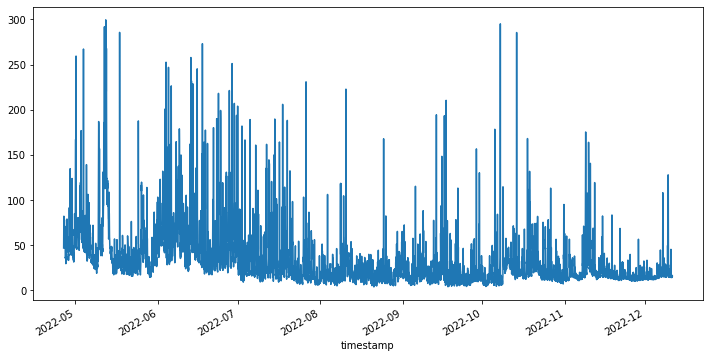

In [6]:
dataset['average_gas_fee'].plot(figsize = (12,6));

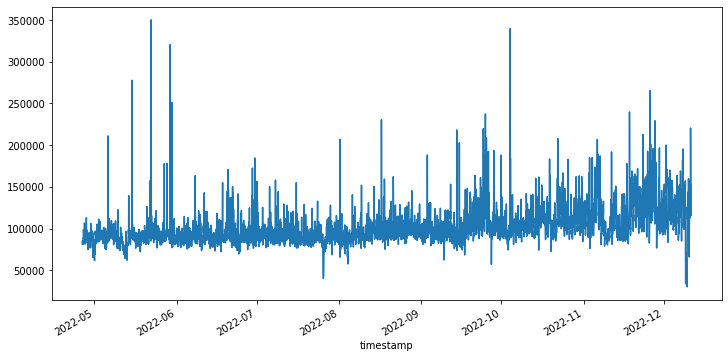

In [7]:
dataset['avgGas'].plot(figsize = (12,6));

In [8]:
dataset_90days.head()

,timestamp,average_gas_fee,avgGas,Bitcoin Price (USD),Ethereum Price (USD)
0,2022-09-12 10:00:00,10.585,92232.945200,22195.69118,1750.655946
1,2022-09-12 11:00:00,30.230,88143.438267,22180.53379,1746.531098
2,2022-09-12 12:00:00,33.410,82982.461422,22292.74291,1751.864674
3,2022-09-12 13:00:00,25.225,84544.989353,22359.17007,1747.678093
4,2022-09-12 14:00:00,52.245,89251.971497,22391.44726,1752.387514


In [9]:
df_log = np.log(dataset['average_gas_fee'])

**During EDA, we saw that ASF for log differenced data "cuts off" after 1 lag, however PACF does not die out and stays significant. That makes hard for us to pick the orders for AR(p) or MA(q). We will first try to build a simple model MA(1) and then a seasonal ARIMA model with daily frequency (24) with different p,q,P,Q orders. After that we will run auto arima on our log data, without including the seasonality term, and compare its best outcome with eariler models.**

## Model Development and Evaluation for Average Gas Price (without exogenous variables)

## Model Building Part (Traditional Models)

In [10]:
print(len(df_log))
print(len(df_log) * 0.05)

5487
274.35


In [55]:
split_ratio = 0.95

In [11]:
#Split data as train set, test set
train_set, test_set = train_test_split(df_log, test_size = 1 - split_ratio, shuffle=False)

In [12]:
vanilla_model = sm.tsa.arima.ARIMA(train_set, order = (0,1,1)).fit()
print(vanilla_model.summary())

                               SARIMAX Results                                
Dep. Variable:        average_gas_fee   No. Observations:                 5212
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3150.890
Date:                Thu, 15 Dec 2022   AIC                           6305.780
Time:                        07:45:04   BIC                           6318.898
Sample:                             0   HQIC                          6310.368
                               - 5212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4518      0.009    -50.716      0.000      -0.469      -0.434
sigma2         0.1962      0.002     79.571      0.000       0.191       0.201
Ljung-Box (L1) (Q):                   2.73   Jarque-

In [13]:
model_24 = sm.tsa.arima.ARIMA(train_set, order= (0,1,1), seasonal_order = (0,1,1,24)).fit()
print(model_24.summary())

                                    SARIMAX Results                                     
Dep. Variable:                  average_gas_fee   No. Observations:                 5212
Model:             ARIMA(0, 1, 1)x(0, 1, 1, 24)   Log Likelihood               -2815.271
Date:                          Thu, 15 Dec 2022   AIC                           5636.541
Time:                                  07:45:20   BIC                           5656.203
Sample:                                       0   HQIC                          5643.419
                                         - 5212                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6782      0.008    -83.007      0.000      -0.694      -0.662
ma.S.L24      -0.9346      0.004   -208.372      0.

**Let's add AR lag1 term also to the above model and see the results.**

In [14]:
model_24 = sm.tsa.arima.ARIMA(train_set, order= (1,1,1), seasonal_order = (1,1,1,24)).fit()
print(model_24.summary())

                                    SARIMAX Results                                     
Dep. Variable:                  average_gas_fee   No. Observations:                 5212
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood               -2749.677
Date:                          Thu, 15 Dec 2022   AIC                           5509.355
Time:                                  07:46:08   BIC                           5542.124
Sample:                                       0   HQIC                          5520.818
                                         - 5212                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2643      0.013     20.152      0.000       0.239       0.290
ma.L1         -0.8573      0.008   -102.300      0.

**We can see that the variable ar.S.L24 is statistically insignificant, so we don't need to include that variable in our model.**

In [15]:
model_24 = sm.tsa.arima.ARIMA(train_set, order= (1,1,1), seasonal_order = (0,1,1,24)).fit()
print(model_24.summary())

                                    SARIMAX Results                                     
Dep. Variable:                  average_gas_fee   No. Observations:                 5212
Model:             ARIMA(1, 1, 1)x(0, 1, 1, 24)   Log Likelihood               -2749.712
Date:                          Thu, 15 Dec 2022   AIC                           5507.423
Time:                                  07:46:34   BIC                           5533.639
Sample:                                       0   HQIC                          5516.594
                                         - 5212                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2645      0.013     20.163      0.000       0.239       0.290
ma.L1         -0.8573      0.008   -102.311      0.

In [16]:
model_auto = pm.auto_arima(train_set, d=1,
                      start_p=1, start_q=0, max_order = 6, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6517.455, Time=1.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7183.392, Time=0.42 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6307.773, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7181.393, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6291.158, Time=2.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6010.476, Time=7.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6366.310, Time=0.93 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5987.110, Time=9.76 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=6318.495, Time=1.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=5988.288, Time=11.03 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6013.151, Time=10.81 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5998.006, Time=10.80 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=6313.078, Time=1.31 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=5988.622, Time=13.94 sec
 ARIMA(3,1,1)(0,0,0)[0]      

**The optimal model here is ARIMA(3,1,1), which has AIC of 6171.480. However, the seasonal ARIMA(1,1,1)(0,1,1,24) that we built earlier has a better AIC of approximately 5672. So we will choose this model.**

In [19]:
model_24 = sm.tsa.arima.ARIMA(train_set, order= (3,1,1), seasonal_order = (0,1,1,24))
results_24 = model_24.fit()

print(results_24.summary())

                                    SARIMAX Results                                     
Dep. Variable:                  average_gas_fee   No. Observations:                 5212
Model:             ARIMA(3, 1, 1)x(0, 1, 1, 24)   Log Likelihood               -2726.611
Date:                          Thu, 15 Dec 2022   AIC                           5465.222
Time:                                  07:55:23   BIC                           5504.546
Sample:                                       0   HQIC                          5478.979
                                         - 5212                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3068      0.013     24.392      0.000       0.282       0.331
ar.L2          0.0963      0.014      6.997      0.

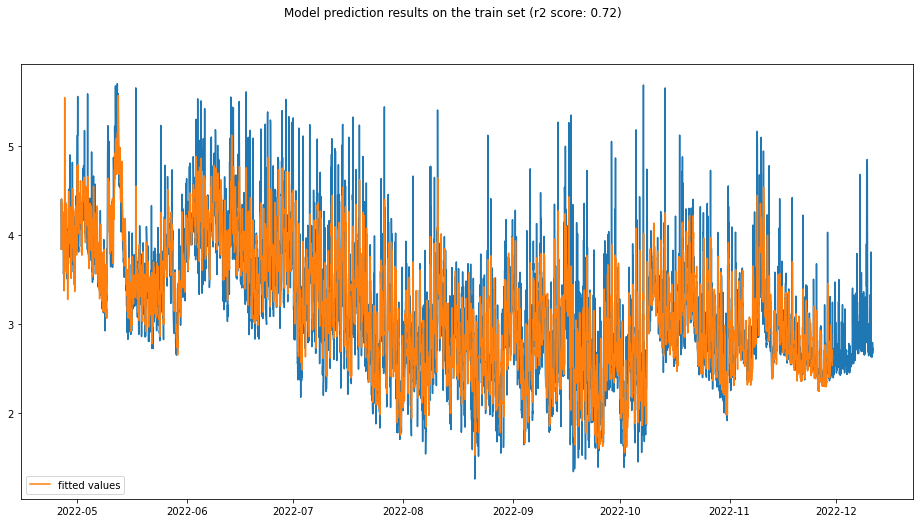

In [21]:
fig, ax= plt.subplots(figsize=(16,8))
ax.plot(df_log.index, df_log)
ax.plot(train_set.index[1:], results_24.predict()[1:], label='fitted values')
ax.legend(loc='lower left')
r2_train = r2_score(train_set[1:], results_24.predict()[1:])
plt.suptitle(f'Model prediction results on the train set (r2 score: {round(r2_train, 2)})')
plt.show()

## Residual Analysis Part

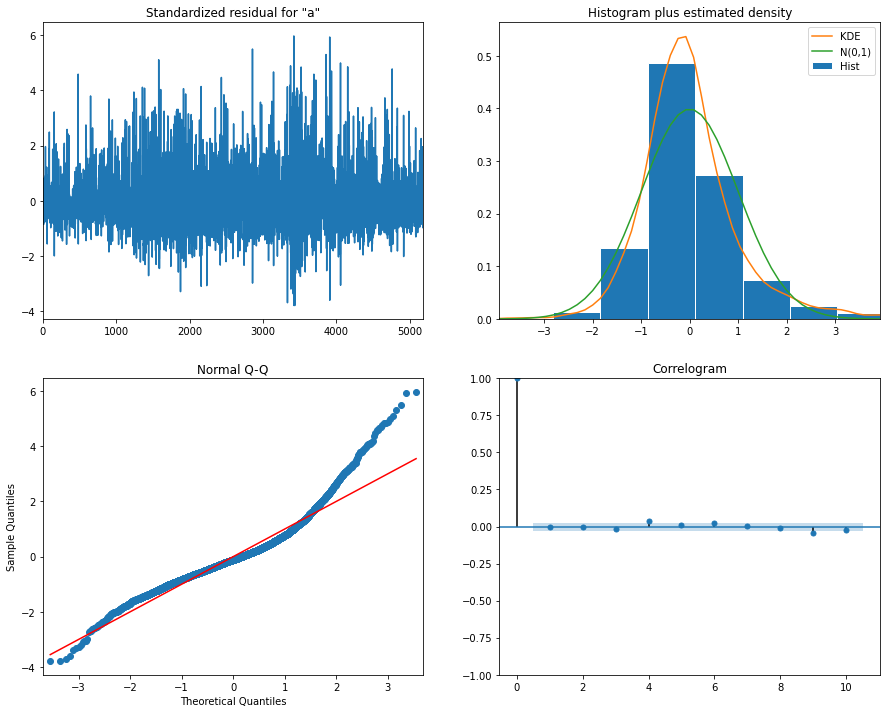

In [22]:
results_24.plot_diagnostics(figsize=(15,12))
plt.show()

## Forecasting

In [23]:
# get the forcasted value from our model
y_pred_24 = results_24.get_forecast(len(test_set))

pred = y_pred_24
pred_value = pred.predicted_mean
pred_index = list(test_set.index)

In [24]:
pred_value

5212    2.460778
5213    2.434519
5214    2.499127
5215    2.427421
5216    2.451766
          ...   
5482    2.190497
5483    2.189091
5484    2.187814
5485    2.272788
5486    2.219589
Name: predicted_mean, Length: 275, dtype: float64

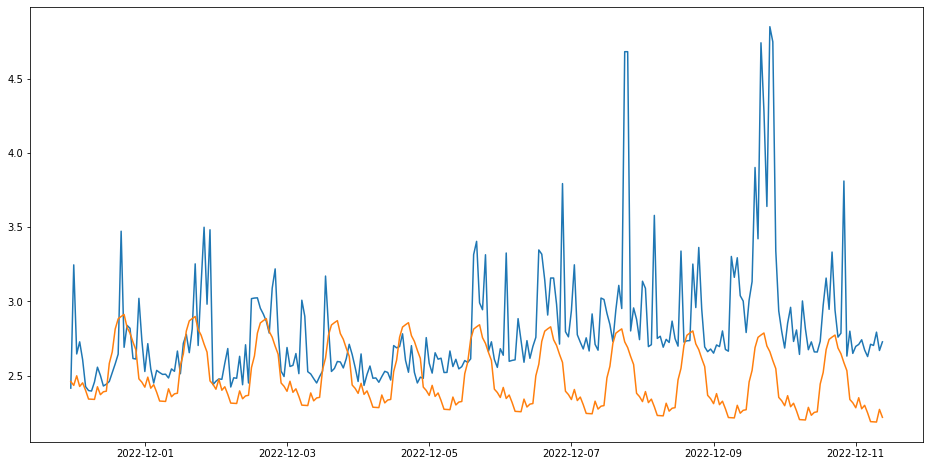

In [25]:
plt.figure(figsize = (16,8))
plt.plot(pred_index, df_log[pred_index])
plt.plot(pred_index, pred_value)
plt.show()

In [26]:
model_24_future = sm.tsa.arima.ARIMA(test_set, order= (3,1,1), seasonal_order = (0,1,1,24))
res_24_future = model_24_future.smooth(results_24.params)

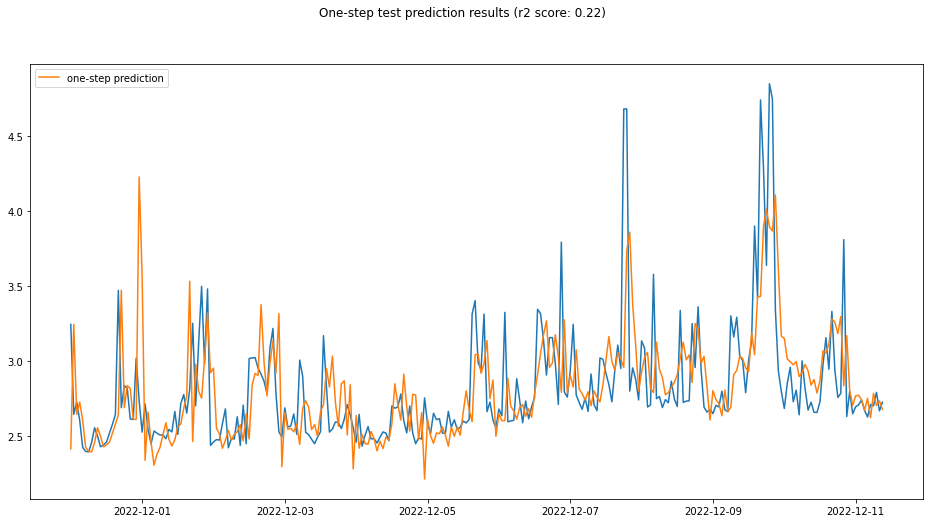

In [29]:
fig, ax= plt.subplots(figsize=(16,8))
ax.plot(test_set.index[1:], test_set[1:])
ax.plot(test_set.index[1:], res_24_future.predict()[1:], label='one-step prediction')
ax.legend(loc='upper left')
r2_test = r2_score(test_set[1:], res_24_future.predict()[1:])
#r2_test = r2_score(test_set, res_24_future.forecasts.ravel()[1:])
plt.suptitle(f'One-step test prediction results (r2 score: {round(r2_test, 2)})')
plt.show()

## Deep Learning Models

In [138]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [139]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

In [140]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

In [174]:
# min-max scale
sc = MinMaxScaler()
training_data = sc.fit_transform(df_log.values.reshape(-1,1))

# using previous 24 hours
seq_length = 24

x, y = sliding_windows(training_data, seq_length)

In [175]:
train_size = int(len(y) * split_ratio)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [176]:
input_size = 1
hidden_size = 2
num_layers = 1
num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

In [177]:
# Loss and Optimizer Setting
criterion = torch.nn.MSELoss()    # mean-squared error for regression

learning_rate = 0.1
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)


In [178]:
num_epochs = 2000

# Train the model
for epoch in range(num_epochs):
    
    optimizer.zero_grad()
    outputs = lstm(trainX)

    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.07388
Epoch: 100, loss: 0.00964
Epoch: 200, loss: 0.00963
Epoch: 300, loss: 0.00959
Epoch: 400, loss: 0.00952
Epoch: 500, loss: 0.00943
Epoch: 600, loss: 0.00929
Epoch: 700, loss: 0.01463
Epoch: 800, loss: 0.00915
Epoch: 900, loss: 0.00906
Epoch: 1000, loss: 0.00905
Epoch: 1100, loss: 0.00902
Epoch: 1200, loss: 0.00897
Epoch: 1300, loss: 0.00899
Epoch: 1400, loss: 0.00897
Epoch: 1500, loss: 0.00887
Epoch: 1600, loss: 0.00936
Epoch: 1700, loss: 0.00866
Epoch: 1800, loss: 0.00860
Epoch: 1900, loss: 0.00859


In [179]:
def plot_res(dataX, dataY):
  lstm.eval()
  with torch.no_grad():
    predict = lstm(dataX)

  data_predict = predict.data.numpy()
  dataY_plot = dataY.data.numpy()

  data_predict = sc.inverse_transform(data_predict)
  dataY_plot = sc.inverse_transform(dataY_plot)


  plt.figure(figsize = (16,8))
  plt.plot(dataY_plot)
  plt.plot(data_predict)
  r2_train = r2_score(dataY_plot, data_predict)
  plt.suptitle(f'Time-Series Prediction using LSTM (r2_score: {round(r2_train, 2)})')
  plt.show()

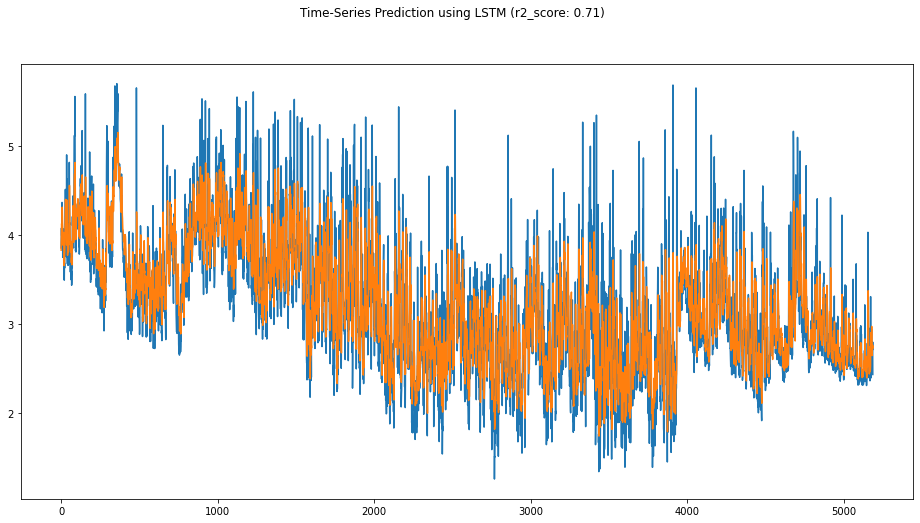

In [180]:
plot_res(trainX, trainY)

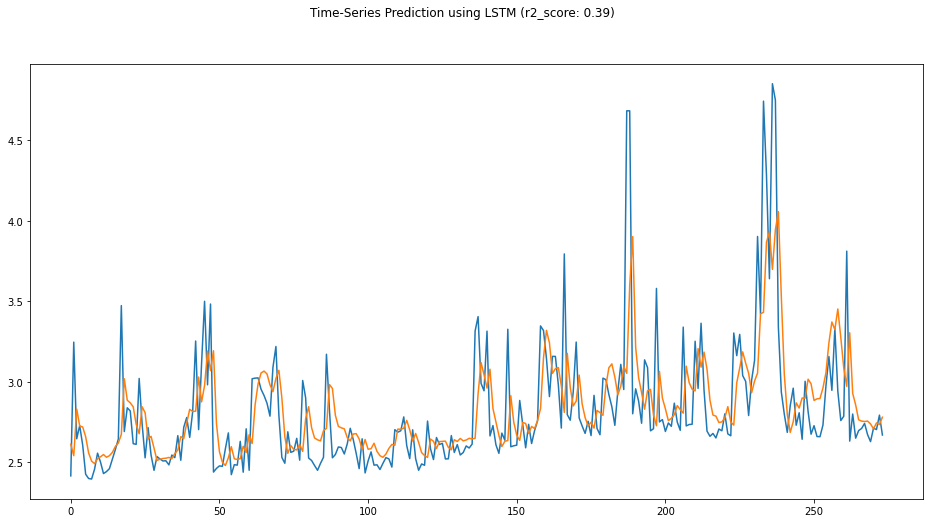

In [181]:
plot_res(testX, testY)

## Model Development and Evaluation for Average Gas Price (wit exogenous variables)

In [205]:
dataset_90days = pd.read_csv('train_df_90days.csv')

In [206]:
dataset_90days.head()

,timestamp,average_gas_fee,avgGas,Bitcoin Price (USD),Ethereum Price (USD)
0,2022-09-12 10:00:00,10.585,92232.945200,22195.69118,1750.655946
1,2022-09-12 11:00:00,30.230,88143.438267,22180.53379,1746.531098
2,2022-09-12 12:00:00,33.410,82982.461422,22292.74291,1751.864674
3,2022-09-12 13:00:00,25.225,84544.989353,22359.17007,1747.678093
4,2022-09-12 14:00:00,52.245,89251.971497,22391.44726,1752.387514


In [207]:
#dataset_90days.drop('avgGas', axis = 1, inplace = True)

In [208]:
dataset_90days.set_index('timestamp', drop = True, inplace = True)
dataset_90days.head()

,average_gas_fee,avgGas,Bitcoin Price (USD),Ethereum Price (USD)
timestamp,,,,
2022-09-12 10:00:00,10.585,92232.945200,22195.69118,1750.655946
2022-09-12 11:00:00,30.230,88143.438267,22180.53379,1746.531098
2022-09-12 12:00:00,33.410,82982.461422,22292.74291,1751.864674
2022-09-12 13:00:00,25.225,84544.989353,22359.17007,1747.678093
2022-09-12 14:00:00,52.245,89251.971497,22391.44726,1752.387514


In [209]:
df_90days = dataset_90days.copy()

for col in df_90days.columns:
  #df_90days.loc[:, col] = np.log(df_90days[col]).diff(periods = 1)
  df_90days.loc[:, col] = np.log(df_90days[col])
#df_90days.drop('2022-09-12 10:00:00', axis = 0, inplace = True)
df_90days.head()

,average_gas_fee,avgGas,Bitcoin Price (USD),Ethereum Price (USD)
timestamp,,,,
2022-09-12 10:00:00,2.359438,11.432073,10.007653,7.467746
2022-09-12 11:00:00,3.408835,11.386721,10.006970,7.465387
2022-09-12 12:00:00,3.508855,11.326385,10.012016,7.468436
2022-09-12 13:00:00,3.227836,11.345039,10.014992,7.466043
2022-09-12 14:00:00,3.955944,11.399219,10.016434,7.468734


In [211]:
model_X = sm.tsa.arima.ARIMA(df_90days['average_gas_fee'], exog = df_90days.iloc[:,-3:], order= (3,1,1), seasonal_order = (0,1,1,24))
results_X = model_X.fit()
print(results_X.summary())

                                    SARIMAX Results                                     
Dep. Variable:                  average_gas_fee   No. Observations:                 2149
Model:             ARIMA(3, 1, 1)x(0, 1, 1, 24)   Log Likelihood               -1227.718
Date:                          Thu, 15 Dec 2022   AIC                           2473.436
Time:                                  12:22:48   BIC                           2524.385
Sample:                                       0   HQIC                          2492.086
                                         - 2149                                         
Covariance Type:                            opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
avgGas                  -0.4566      0.057     -8.060      0.000      -0.568      -0.346
Bitcoin Price (USD)  